# Plotting news articles with NLP

This is a quick mock up I did to see if we could plot news articles with NLP. I used a very clean [kaggle dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset) which had the category, title, and short description of each article. 

From the headline and description, I made a vector of words in each article using [word2vec](https://en.wikipedia.org/wiki/Word2vec). Now we have an array where each row represents an article, and there are 100 columns of numbers that represents the text.

In order to plot this data, we need to reduce the number of columns from 100 to 2 (for a 2d plot). I used PCA and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to do this.

The python plots are fine, but I needed a tooltip to see the article title and description. 

I exported the dataframe to tableau public and made the visualization [here](https://public.tableau.com/app/profile/madison.ebersole/viz/newsscatterplotproofofconcept/Sheet1#1) .

In [5]:
# data from https://www.kaggle.com/datasets/rmisra/news-category-dataset
import json

data = []
for line in open('../../data/News_Category_Dataset_v3.json'):
    data.append(json.loads(line))

# to pandas dataframe
import pandas as pd
df = pd.json_normalize(data)

# randomly sample 1000 rows
df = df.sample(n=1000)

df.head()

,link,headline,category,short_description,authors,date
16259,https://www.huffingtonpost.com/entry/oil-tanke...,Stricken Tanker Leaks 8-Mile Long Oil Slick In...,WORLD NEWS,A clean-up effort has begun and rescue teams h...,,2018-01-15
71691,https://www.huffingtonpost.com/entry/promise-n...,Promise Not Peril: Can Investing in Health Det...,WORLDPOST,"The concept of ""health as a bridge for peace"" ...","Siddharth Chatterjee, ContributorUnited Nation...",2016-03-27
198122,https://www.huffingtonpost.com/entry/cornwall-...,"Cornwall, England: Tourism, Pub-Going And Dini...",TRAVEL,There are evidently fewer pubs than there used...,"Edward Schneider, Contributor\nTravel, cooking...",2012-05-30
8554,https://www.huffpost.com/entry/united-states-g...,The United States Is Now The Global Leader In ...,WORLD NEWS,A staggering number of people are seeking safe...,Willa Frej,2018-06-20
53788,https://www.huffingtonpost.com/entry/colin-kae...,Bills Fans Kneel In Solidarity With Colin Kaep...,SPORTS,A group of protesters supported the quarterbac...,Travis Waldron,2016-10-16


In [6]:
# make headline and short description into one column
df['text'] = df['headline'] + ' ' + df['short_description']

list_of_text = df['text'].to_list()

# NLP: text pre-processing with nltk


In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora

en_stop = set(stopwords.words('english'))

def get_lemma2(word):
    from nltk.stem.wordnet import WordNetLemmatizer
    """
    This function takes a word and returns its rootword
    """
    return WordNetLemmatizer().lemmatize(word)
# remove extra characters
import re
def clean_chr(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def nltk_preprocessing(text):
    """
    This function takes a text and returns a list of tokens
    - lowercase
    - remove short words
    - remove stopwords
    - remove extra characters
    - gets root word (lemma)

    """
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if len(token) > 4]      # remove short words
    tokens = [token for token in tokens if token not in en_stop] # remove stopwords
    tokens = [clean_chr(token) for token in tokens]              # remove extra characters
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

ModuleNotFoundError: No module named 'nltk'

In [ ]:
# clean data
clean_train_text = [nltk_preprocessing(text) for text in list_of_text]

# tag each document with its category
from gensim.models.doc2vec import TaggedDocument
tagged_train_text = [TaggedDocument(words=text, tags="doc") for text, category in zip(clean_train_text, df['category'])]

# Doc2Vec with gensim

In [ ]:
from gensim.models import doc2vec

n_space = 100

# train doc2vec model
model_d2v = doc2vec.Doc2Vec(documents=tagged_train_text, vector_size=n_space, window=5, min_count=1, workers=4, epochs=100)

# get document vectors
doc_vecs = [model_d2v.infer_vector(text) for text in clean_train_text]

# convert to numpy array
import numpy as np
doc_vecs = np.array(doc_vecs)

now we have a vector representation of each word in our list `word_vecs` which looks like: 
```
array([[ 0.68491604,  2.01373113,  2.59129064, ...,  0.37546405,
        -1.49053731, -0.43113023],
       [ 0.42085448,  0.26101776,  0.38303052, ..., -0.08395418,
        -0.68023642,  0.69063785],...
```

one row for each of the 1000 articles and each column is a dimension of the vector (we arbitrarily chose 100 dimensions).

# Plot this (1000,100) matrix as a 2D scatter plot

To do this we have to reduce the number of columns from 100 to 2... to do this we use a dimentionality reduction model. One model is PCA.


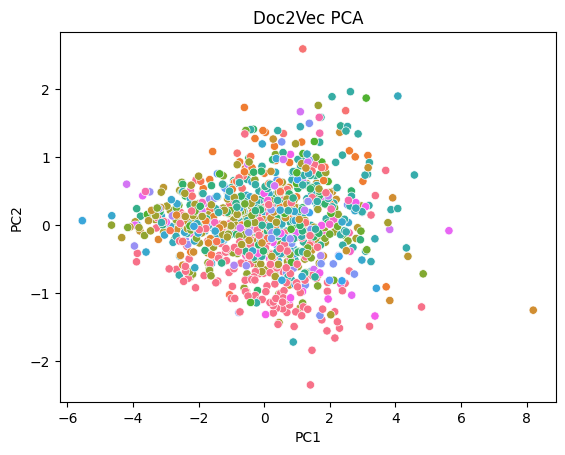

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# reduce to 2 dimensions
pca = PCA(n_components=2)
pca.fit(doc_vecs)
pca_coord = pca.transform(doc_vecs)

# plot
import seaborn as sns
sns.scatterplot(x=pca_coord[:,0], y=pca_coord[:,1], hue=df['category'])

# hide the legend
plt.legend().set_visible(False)

import matplotlib.pyplot as plt
plt.xlabel('PC1')
plt.ylabel('PC2')

# remember the x and y don't really mean anything... just the relative distance between points
plt.title('Doc2Vec PCA')
plt.show()


For this plot, each dot represents one article, colored by the category (given in the dataset). There are a few points that are way out in space.. those might be interesting to explore. But we don't see any clear clusters of articles... maybe we need to do some more work on the text pre-processing.

/home/madis/sandbox/nlp-sandbox/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


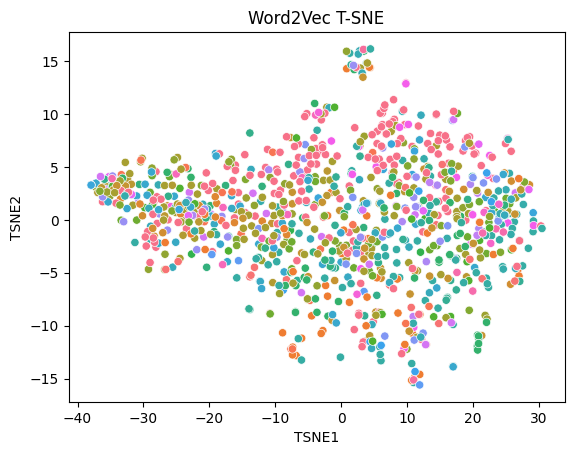

In [ ]:
# tsne is another dimensionality reduction technique. It is more computationally expensive than PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000,  random_state=0, init='pca', learning_rate='auto')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(doc_vecs)

# plot tsne
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=df['category'])
# hide the legend
plt.legend().set_visible(False)

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

# remember the x and y don't really mean anything... just the relative distance between points
plt.title('Word2Vec T-SNE')
plt.show()


In [ ]:
# do the same thing but with umap
# import umap from sklearn
from sklearn.manifold import Isomap

umap = Isomap(n_components=2, n_neighbors=15)
umap_coord = umap.fit_transform(doc_vecs)

# plot umap
import seaborn as sns
sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], hue=df['category'])
# hide the legend
plt.legend().set_visible(False)

import matplotlib.pyplot as plt
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# remember the x and y don't really mean anything... just the relative distance between points
plt.title('Word2Vec UMAP')

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# append Y to df
df['x'] = Y[:,0]
df['y'] = Y[:,1]

# save df
df.to_csv('../../data/news.csv', index=False)

df.head()

,link,headline,category,short_description,authors,date,text,x,y
72798,https://www.huffingtonpost.com/entry/teens-aga...,These Teens Are Begging You Not To Vote For Trump,POLITICS,"Wise beyond their years, or just basically dec...",Ryan Grim,2016-03-14,These Teens Are Begging You Not To Vote For Tr...,-14.617010,6.159631
134919,https://www.huffingtonpost.com/entry/blended-f...,This Stepkid Has Some Helpful Advice On Dealin...,DIVORCE,What makes you proudest of your family today? ...,,2014-04-04,This Stepkid Has Some Helpful Advice On Dealin...,7.355359,-6.161557
115133,https://www.huffingtonpost.com/entry/cape-day-...,4-Year-Old 'Super DJ' Passes Out Capes To Kids...,PARENTS,,Caroline Bologna,2014-11-17,4-Year-Old 'Super DJ' Passes Out Capes To Kids...,-20.758909,-0.174206
141151,https://www.huffingtonpost.com/entry/gps-track...,GPS Tracking Devices for Kids with Autism?,PARENTING,Schumer's proposed legislation is that the fed...,"William Stillman, Contributor\nAward-winning a...",2014-01-27,GPS Tracking Devices for Kids with Autism? Sch...,8.627761,-8.807384
52820,https://www.huffingtonpost.com/entry/girl-head...,This Is Why You Should Never Stick Your Head I...,WEIRD NEWS,Do we need to call the fire department?,Steven Hoffer,2016-10-27,This Is Why You Should Never Stick Your Head I...,-33.480537,1.971095
